**Import necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

**Load the Seismic Data**

In [2]:
GroundAccel = pd.read_csv("El-Centro-2.txt", delimiter='\s+') # time [t] vs. g
GroundAccel["ug_ddot"] *= 9.81 # [m/s2]
GroundAccel.head(3) # Display first 3 rows to check the data

,t,ug_ddot
0,0.000,0.014715
1,0.005,0.020601
2,0.010,0.052974


**Plot the ground acceleration data**

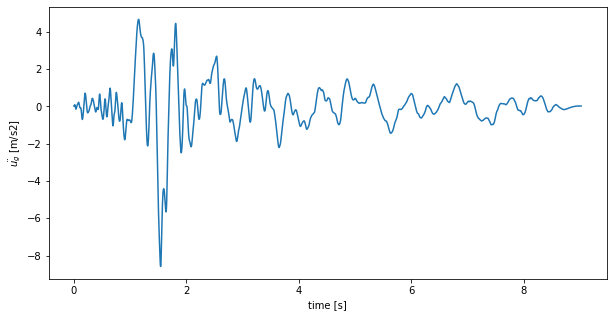

In [3]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(GroundAccel["t"], GroundAccel["ug_ddot"])
ax.set_xlabel("time [s]")
ax.set_ylabel("$\ddot{u_g}$ [m/s2]")
plt.show()

**A function to obtain recurrence coeff. (Aydınoğlu, 2003)**

In [4]:
def recurr_coeff(beta_ej, ksi, omega, deltat):
    if (abs(beta_ej)<1e-10):
        if (abs(ksi)<1e-10):
            A11 = 1
            A12 = deltat
            A21 = 0
            A22 = 1
            B11 = -(1./2.)*deltat**2
            B12 = -(1./6.)*deltat**2
            B21 = -A12
            B22 = B11/delta
            return [A11, A12, A21, A22, B11, B12, B21, B22]
        else:
            eta = 2*ksi*omega
            G = math.exp(-eta*deltat)
            A11 = 1
            A12 = (1-G)/eta
            A21 = 0
            A22 = G
            B11 = (A12-deltat)/eta
            B12 = -(B11/deltat+0.5*deltat)/eta
            B21 = -A12
            B22 = B11/deltat
            return [A11, A12, A21, A22, B11, B12, B21, B22]
    else:
        if (abs(beta_ej-ksi**2)<1e-10):
            A11 = (1+ksi*omega*deltat)*math.exp(-ksi*omega*deltat)
            A12 = deltat*math.exp(-ksi*omega*deltat)
            A21 = -beta_ej*(omega**2)*A12
            A22 = (1-ksi*omega*deltat)*math.exp(-ksi*omega*deltat)
        else:
            if (beta_ej>ksi**2):
                omegaD = omega*(beta_ej-ksi**2)**0.5
                E = math.cos(omegaD*deltat)*math.exp(-ksi*omega*deltat)
                F = math.sin(omegaD*deltat)*math.exp(-ksi*omega*deltat)
            else:
                omegaD = omega*(-beta_ej+ksi**2)**0.5
                E = math.cosh(omegaD*deltat)*math.exp(-ksi*omega*deltat)
                F = math.sinh(omegaD*deltat)*math.exp(-ksi*omega*deltat)
            A11 = E+(ksi*omega/omegaD)*F
            A12 = F/omegaD
            A21 = -beta_ej*(omega**2)*A12
            A22 = E-(ksi*omega/omegaD)*F
        B11 = (A11-1)/(beta_ej*omega**2)
        B12 = (A12-2*ksi*omega*B11-deltat)/(beta_ej*(omega**2)*deltat)
        B21 = -A12
        B22 = B11/deltat
        return [A11, A12, A21, A22, B11, B12, B21, B22]  

**Define the function which performs time stepping**

In [5]:
def hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend):
    """"
    Inputs:
    T : initial period [s]
    ksi : linear damping coeff.
    alpha : post-yield stiffness ratio
    theta : stability coeff.
    fy_over_m : yield pseudo-acc. [m/s2]
    deltat : time step [s]
    tend : end time of simulation [s]
    
    Outputs:
    u_arr : displacements [m]
    u_dot_arr : velocities [m/s]
    u_ddot_arr : accelerations [m/s2]
    fs_over_m_arr : pseudo-acc.  [m/s2]
    t_arr : corresponding times [s]
    """
    omega = 2*math.pi/T # Initial natural freq.
    
    beta_ej_elastic = 1-theta # Effective stiffness ratio for elastic segments
    beta_ej_yielding = alpha-theta # Effective stiffness ratio for yielding segments
    
    t = 0 # Initial time
    u = 0 # Initial displacement
    u_dot = 0 # Initial velocity
    fs_over_m = 0 # Initial pseudo-acc.
    mode = "elastic" # Starting mode - elastic or yielding
    beta_ej = beta_ej_elastic # Initial effective stiffness ratio 
    ug_ddot = np.interp(t, GroundAccel["t"], GroundAccel["ug_ddot"]) # Ground accel at t=0
    uG_ddot = ug_ddot+fs_over_m-beta_ej*(omega**2)*u # Effective pseudo ground accel at t=0
    
    # Initiate arrays to store data for post-processing
    u_arr = [u]
    u_dot_arr = [u_dot]
    u_ddot_arr = [-uG_ddot]
    fs_over_m_arr = [fs_over_m]
    t_arr = [t]
    
    deltat_ref = deltat # Input time step to be used as reference.
                        # At the intersection points of linear segments,
                        # a smaller time step may be required. 
            
    while (t<tend):
        t += deltat 
        
        # Save old solutions
        ug_ddot_old = ug_ddot
        u_old = u
        u_dot_old = u_dot
        fs_over_m_old = fs_over_m
        
        # Calculate ground acceleration increment
        ug_ddot = np.interp(t, GroundAccel["t"], GroundAccel["ug_ddot"])
        delta_ug_ddot = ug_ddot-ug_ddot_old
        
        # Update u, u_dot and fs_over_m for elastic mode
        if (mode == "elastic"):
            AB = recurr_coeff(beta_ej, ksi, omega, deltat)
            u = AB[0]*u_old+AB[1]*u_dot_old+AB[4]*uG_ddot+AB[5]*delta_ug_ddot
            u_dot = AB[2]*u_old+AB[3]*u_dot_old+AB[6]*uG_ddot+AB[7]*delta_ug_ddot
            u_ddot = -2*ksi*omega*u_dot-beta_ej*(omega**2)*u-uG_ddot-delta_ug_ddot
            fs_over_m += beta_ej*(omega**2)*(u-u_old)
            
            # Check for plastic transition
            fy_over_m_TOP = beta_ej_yielding*(omega**2)*u+(1-alpha)*fy_over_m
            fy_over_m_BOTTOM = beta_ej_yielding*(omega**2)*u-(1-alpha)*fy_over_m
            
            if (fs_over_m>fy_over_m_TOP or fs_over_m<fy_over_m_BOTTOM):
                if (abs(fs_over_m-fy_over_m_TOP)<1e-10 or abs(fs_over_m-fy_over_m_BOTTOM)<1e-10):
                    mode = "yielding"
                    beta_ej = beta_ej_yielding
                    deltat = deltat_ref
                else:
                    ug_ddot = ug_ddot_old
                    u = u_old
                    u_dot = u_dot_old
                    fs_over_m = fs_over_m_old
                    t -= deltat
                    deltat *= 0.5
                    continue
                    
        # Update u, u_dot and fs_over_m for plastic mode                    
        elif (mode == "yielding"): 
            AB = recurr_coeff(beta_ej, ksi, omega, deltat)
            u = AB[0]*u_old+AB[1]*u_dot_old+AB[4]*uG_ddot+AB[5]*delta_ug_ddot
            u_dot = AB[2]*u_old+AB[3]*u_dot_old+AB[6]*uG_ddot+AB[7]*delta_ug_ddot
            u_ddot = -2*ksi*omega*u_dot-beta_ej*(omega**2)*u-uG_ddot-delta_ug_ddot
            fs_over_m += beta_ej*(omega**2)*(u-u_old)
            
            # Check for elastic transition
            if ((u_dot>0 and u_dot_old<0) or (u_dot<0 and u_dot_old>0)):
                if abs(u_dot)<1e-10:
                    mode = "elastic"
                    beta_ej = beta_ej_elastic
                    deltat = deltat_ref
                else:
                    ug_ddot = ug_ddot_old
                    u = u_old
                    u_dot = u_dot_old
                    fs_over_m = fs_over_m_old
                    t -= deltat
                    deltat *= 0.5
                    continue
                    
        uG_ddot = ug_ddot+fs_over_m-beta_ej*(omega**2)*u # Calculate effective pseudo-acc.
        
        # Fill the arrays for post-processing
        u_arr.append(u)
        u_dot_arr.append(u_dot)
        u_ddot_arr.append(u_ddot+ug_ddot)
        fs_over_m_arr.append(fs_over_m)
        t_arr.append(t)
        
    return u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr

**Inputs other than initial period**

In [6]:
ksi = 0.003
alpha = 0.0
theta = 0.0
fy_over_m = 1e100
tend = 9.02

**Plot the displacement, velocity and acceleration spectrums**

In [7]:
T = 1e-3
deltaT = 0.02
Tend = 4
u_max_arr = []
u_dot_max_arr = []
u_ddot_max_arr = []
T_arr = []

while(T<Tend):
    deltat = T/100 if T/100<0.005 else 0.005
    
    u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr = \
        hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend)
    
    u_max_arr.append(max(abs(i) for i in u_arr))
    u_dot_max_arr.append(max(abs(i) for i in u_dot_arr))
    u_ddot_max_arr.append(max(abs(i) for i in u_ddot_arr))
    T_arr.append(T)
    
    T += deltaT

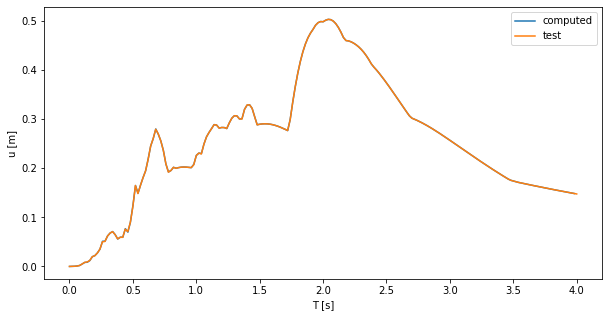

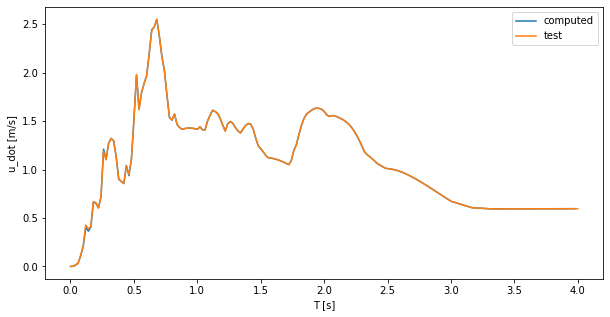

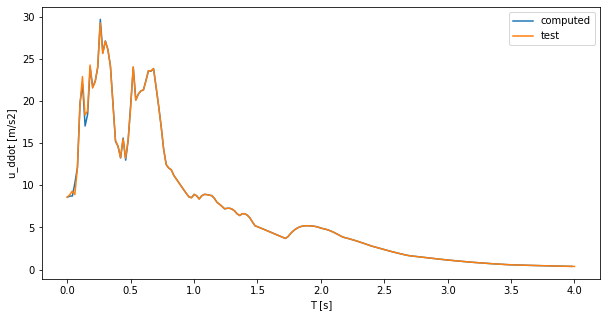

In [8]:
Test = pd.read_csv("Spectrum.txt", delimiter='\s+') 

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(T_arr, u_max_arr, label="computed")
ax.plot(Test["T"], Test["u"], label="test")
ax.set_xlabel("T [s]")
ax.set_ylabel("u [m]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(T_arr, u_dot_max_arr, label="computed")
ax.plot(Test["T"], Test["u_dot"], label="test")
ax.set_xlabel("T [s]")
ax.set_ylabel("u_dot [m/s]")
ax.legend()
plt.show()

Test["u_ddot"] *= 9.81
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(T_arr, u_ddot_max_arr, label="computed")
ax.plot(Test["T"], Test["u_ddot"], label="test")
ax.set_xlabel("T [s]")
ax.set_ylabel("u_ddot [m/s2]")
ax.legend()
plt.show()